<a href="https://colab.research.google.com/github/Federicotrotta24/Predictive-Modeling-of-Drug-Sensitivity-using-GDSC-Dataset/blob/main/Predictive_Modeling_of_Drug_Sensitivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importación de librerías

In [ ]:
!pip install scikit-posthocs

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from scipy.stats import spearmanr, pearsonr, mannwhitneyu, kruskal, shapiro, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import statsmodels.api as sm
import scikit_posthocs as sp


## 2. Carga de datos

In [ ]:
## Pyton
from google.colab import drive
drive.mount('/content/drive') # Added closing single quote

Mounted at /content/drive


In [ ]:
# Ruta de archivos en tu Drive (reemplazar si es necesario)
data = pd.read_csv('/content/drive/MyDrive/Fede - Salud Analytics/Proyectos/Proyecto#3/GDSC_DATASET.csv')


## 3. Limpieza y transformación inicial

In [ ]:
# Transformación de columnas categóricas binarias a numéricas
data['Gene Expression'] = data['Gene Expression'].map({'Y': 1, 'N': 0})
data['Methylation'] = data['Methylation'].map({'Y': 1, 'N': 0})
data['CNA'] = data['CNA'].map({'Y': 1, 'N': 0})

# Transformación de MSI
data['MSI_binary'] = data['Microsatellite instability Status (MSI)'].map({'MSI-H': 1, 'MSS/MSI-L': 0})

# Eliminación de nulos para ciertos análisis
data = data.dropna(subset=['LN_IC50'])


## 4. Análisis exploratorio de IC50 y AUC

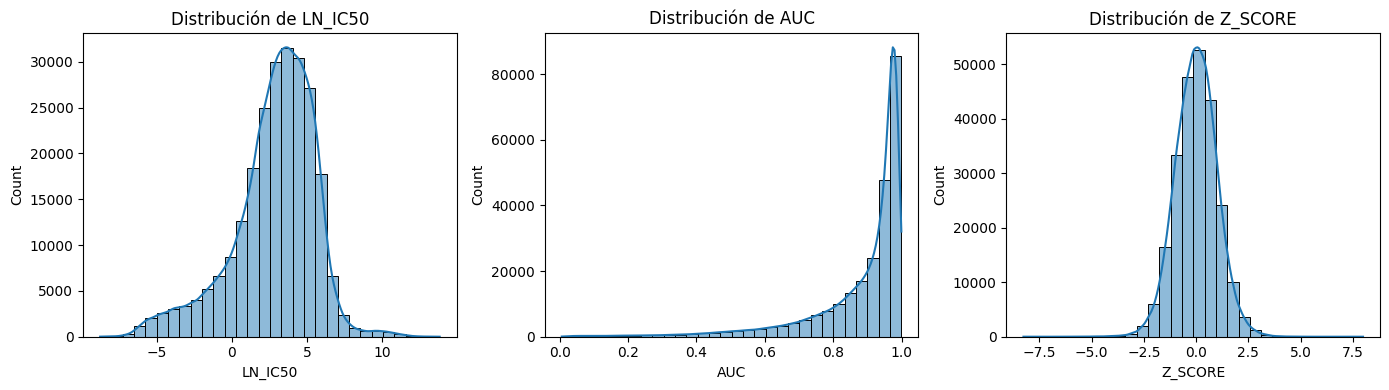

In [ ]:
plt.figure(figsize=(14, 4))
for i, col in enumerate(['LN_IC50', 'AUC', 'Z_SCORE']):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f'Distribución de {col}')
plt.tight_layout()
plt.show()


## 5. Matrices de correlación

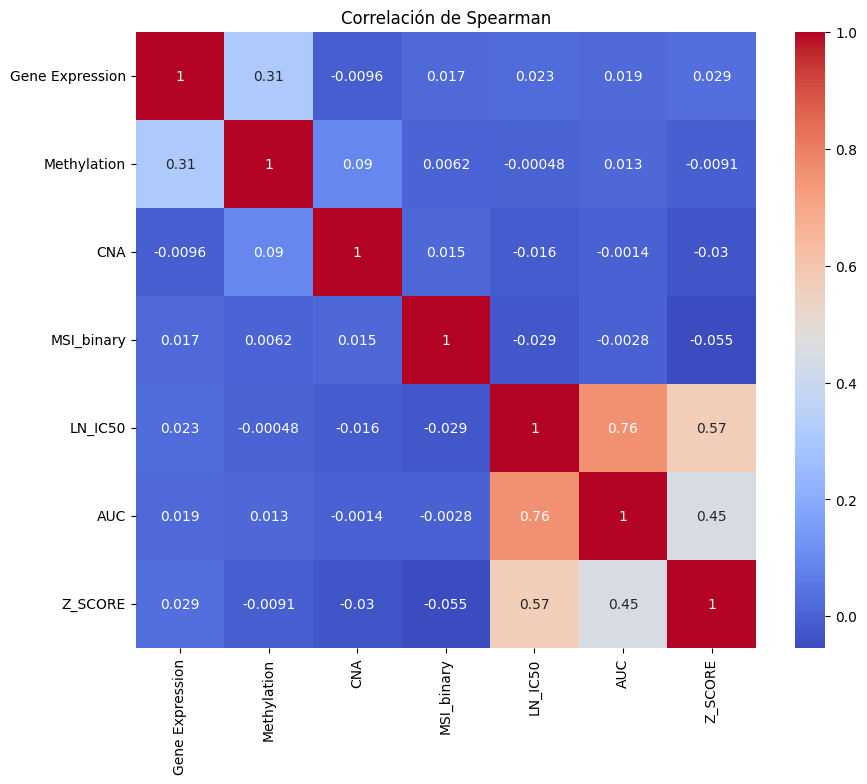

In [ ]:
genomic_features = ['Gene Expression', 'Methylation', 'CNA', 'MSI_binary']
drug_response = ['LN_IC50', 'AUC', 'Z_SCORE']

spearman_corr = data[genomic_features + drug_response].corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm')
plt.title('Correlación de Spearman')
plt.show()


## 6. Pruebas estadísticas para MSI

In [ ]:
msi_high = data[data['MSI_binary'] == 1]['LN_IC50']
msi_low = data[data['MSI_binary'] == 0]['LN_IC50']
stat, p = mannwhitneyu(msi_high, msi_low)
print(f"Mann-Whitney U test: U={stat}, p-value={p}")


Mann-Whitney U test: U=1558198285.5, p-value=1.022330898780796e-42


## 7. Modelo predictivo con LASSO

In [ ]:
# Variables
features = ['Gene Expression', 'Methylation', 'CNA', 'MSI_binary']
X = data[features]
y = data['LN_IC50']

# División
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
modelo = LassoCV(cv=5, random_state=42)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R² score: {r2:.4f}")


ValueError: Input X contains NaN.
LassoCV does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## 8. Importancia de características

In [ ]:
coef = pd.Series(modelo.coef_, index=features)
coef = coef[coef != 0].sort_values(key=abs, ascending=True)

plt.figure(figsize=(8, 4))
coef.plot(kind='barh', color='teal')
plt.title('Coeficientes del modelo LASSO')
plt.xlabel('Magnitud del coeficiente')
plt.grid(True)
plt.tight_layout()
plt.show()


## 9. Modelo predictivo con XGBoost

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Entrenar modelo
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predecir
y_pred = xgb_model.predict(X_test)

# Calcular métricas
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"R² score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


## 10. Importancia de características (XGBoost)

In [ ]:
importances = xgb_model.feature_importances_
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
importance_series = pd.Series(importances, index=feature_names)

# Filtrar top 20
top_features = importance_series.sort_values(ascending=True).tail(20)

# Graficar
plt.figure(figsize=(10, 8))
top_features.plot(kind='barh', color='darkorange')
plt.title('Importancia de características (XGBoost)')
plt.xlabel('Importancia')
plt.tight_layout()
plt.grid(True)
plt.show()


## 11. Feature Engineering con anotaciones de drogas

In [ ]:
compound_annotations = pd.read_csv("/content/drive/MyDrive/Fede - Salud Analytics/Proyectos/Proyecto#3/Compounds-annotation.csv")

top_drugs = [
    'Romidepsin', 'Bortezomib', 'Dactinomycin', 'Daporinad', 'Eg5_9814',
    'Sepantronium bromide', 'Staurosporine', 'Rapamycin', 'Alisertib', 'Dinaciclib'
]

filtered_annotations = compound_annotations[compound_annotations['DRUG_NAME'].isin(top_drugs)]
targets_info = filtered_annotations[['DRUG_NAME', 'TARGET', 'TARGET_PATHWAY']].drop_duplicates()

print("Genes/Proteínas objetivo y vías biológicas asociadas:")
print(targets_info)


## 12. Enrichment Analysis con gseapy

In [ ]:
!pip install gseapy
import gseapy as gp

gene_list = targets_info['TARGET'].to_list()

enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=["Reactome_2016", "KEGG_2016"],
                 organism='human',
                 outdir="enrichment_results",
                 cutoff=0.5)

results_df = enr.results
print(results_df[["Term", "P-value", "Adjusted P-value", "Genes"]])


## 13. Visualización de red Gene ↔ Pathway

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
filtered_df = results_df[results_df['Adjusted P-value'] < 0.05].copy()

for _, row in filtered_df.iterrows():
    pathway = row['Term']
    genes = row['Genes'].split(';')
    for gene in genes:
        gene = gene.strip()
        G.add_node(gene, type='gene')
        G.add_node(pathway, type='pathway')
        G.add_edge(gene, pathway)

pos = nx.spring_layout(G, k=0.5, iterations=50)
genes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'gene']
pathways = [n for n, attr in G.nodes(data=True) if attr['type'] == 'pathway']

plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(G, pos, nodelist=genes, node_color='skyblue', label='Genes', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=pathways, node_color='lightcoral', label='Pathways', node_size=800)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Gene ↔ Pathway Enrichment Network", fontsize=14)
plt.axis('off')
plt.legend(scatterpoints=1)
plt.tight_layout()
plt.show()
